# Tutorial: Loading the Holocene Reconstruction and making figures

## Introduction

This tutorial covers the basics of loading a netCDF file in python, looking at the data, and making a map and a time series. This is aimed at new Python users, to give people a starting point for interacting with paleoclimate reconstructions. There are more advanced ways of interacting with data (e.g., through xarray functionality), but this tutorial uses a basic approach to help users better understand the underlying data.

This tutorial will focus on the Holocene Reconstruction. This general framework can be used to analyze a different reconstruction instead, but you'll need to update some lines to work with a different file.

## Downloading data

Download the Holocene Reconstruction and save it somewhere: https://zenodo.org/record/6426332.

## 1. Import python libraries

First, load some python libraries for additional functionality. If the commands below don't work, you need to install those libraries into your Python environment first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.util as cutil
import xarray as xr
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings('ignore',category=ShapelyDeprecationWarning)

plt.style.use('ggplot')  # This sets the plotting style for the figures we'll be making later.

## 2. Load data

In [2]:
# Specify the location of the file (Note: Change this to the location where you saved the file above.)
data_filename = 'C:/Users/mpe32/Documents/Paleo_data/Holocene_Reconstruction/holocene_reconstruction.nc'

# Load data and print the variables. To read more about these variables, visit https://github.com/Holocene-Reconstruction/Holocene-code
data_xarray = xr.open_dataset(data_filename)
print(data_xarray)

<xarray.Dataset>
Dimensions:                (ages: 1200, lat: 64, lon: 96, ens_selected: 100,
                            ens: 1002, proxy: 1276, metadata: 8, exp_options: 26)
Coordinates:
  * ages                   (ages) float32 4.5 14.5 24.5 ... 1.198e+04 1.199e+04
  * lat                    (lat) float32 -88.59 -85.78 -82.97 ... 85.78 88.59
  * lon                    (lon) float32 0.0 3.75 7.5 ... 348.8 352.5 356.2
Dimensions without coordinates: ens_selected, ens, proxy, metadata, exp_options
Data variables: (12/17)
    recon_tas_mean         (ages, lat, lon) float32 ...
    recon_tas_ens          (ages, ens_selected, lat, lon) float32 ...
    recon_tas_global_mean  (ages, ens) float32 ...
    recon_tas_nh_mean      (ages, ens) float32 ...
    recon_tas_sh_mean      (ages, ens) float32 ...
    prior_tas_mean         (ages, lat, lon) float32 ...
    ...                     ...
    proxy_resolutions      (ages, proxy) float32 ...
    proxy_uncertainty      (proxy) float32 ...
    pr

In [3]:
# Load the values from some variables
tas_mean = data_xarray['recon_tas_mean'].values  # The mean of the temperature reconstruction (Celsius anomalies)
tas_ens  = data_xarray['recon_tas_ens'].values   # 100 ensemble members of the temperature reconstruction (Celsius anomalies)
ages     = data_xarray['ages'].values            # Ages (yr BP)
lat      = data_xarray['lat'].values             # Latitude (degrees N)
lon      = data_xarray['lon'].values             # Longitude (degrees E)

## 3. Basic data interaction

The data above has been loaded into arrays. Here are some basic ways of interacting with it. Read a Python tutorial for a more comprehensive discussion of this topic.

In [4]:
# Print the shape of one of the variables.
print('Shape of tas_mean:',tas_mean.shape)

Shape of tas_mean: (1200, 64, 96)


In [5]:
# Access some values from one of the variables. Python uses 0-indexing, so access the first value with 0, not 1. 
print(tas_mean[0:5,0,0])

[-0.06866396 -0.06214109 -0.0690182  -0.0617621  -0.06216408]


In [6]:
# Print the range of some variables
print('Range of tas_mean:',np.nanmin(tas_mean),np.nanmax(tas_mean))
print('Range of ages:',    np.nanmin(ages),    np.nanmax(ages))
print('Range of lat:',     np.nanmin(lat),     np.nanmax(lat))
print('Range of lon:',     np.nanmin(lon),     np.nanmax(lon))

Range of tas_mean: -16.275763 6.4592714
Range of ages: 4.5 11994.5
Range of lat: -88.59375 88.59375
Range of lon: 0.0 356.25


## 4: Make a map of temperature change between two intervals

In [7]:
# Specify anomaly and reference periods
ages_anom = [5500,6500]
ages_ref  = [0,1000]

# Find indicies of the periods selected above
ind_anom = np.where((ages >= ages_anom[0]) & (ages <= ages_anom[1]))[0]
ind_ref  = np.where((ages >= ages_ref[0])  & (ages <= ages_ref[1]))[0]
print('Data points in anomaly period:',len(ind_anom))
print('Data points in reference period:',len(ind_ref))

# Compute averages
tas_mean_anom = np.mean(tas_mean[ind_anom,:,:],axis=0)
tas_mean_ref  = np.mean(tas_mean[ind_ref,:,:], axis=0)
tas_mean_change = tas_mean_anom - tas_mean_ref

Data points in anomaly period: 100
Data points in reference period: 100


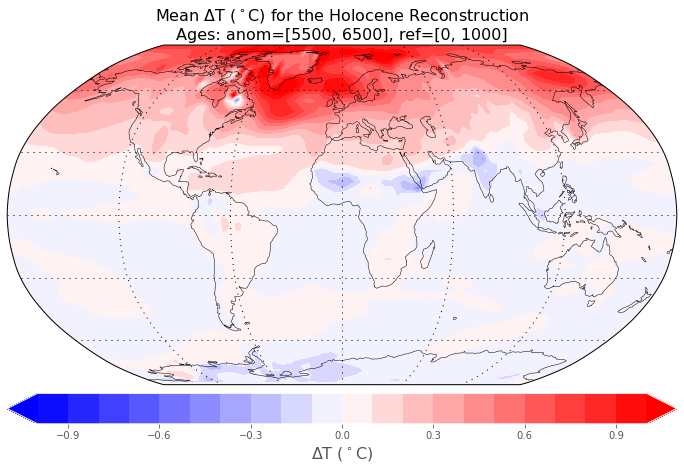

In [8]:
# Make a map
plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((1,1),(0,0),projection=ccrs.Robinson()); ax1.set_global()

tas_change_cyclic,lon_cyclic = cutil.add_cyclic_point(tas_mean_change,coord=lon)
map1 = ax1.contourf(lon_cyclic,lat,tas_change_cyclic,np.arange(-1,1.1,.1),extend='both',cmap='bwr',transform=ccrs.PlateCarree())
colorbar1 = plt.colorbar(map1,orientation='horizontal',ax=ax1,fraction=0.08,pad=0.02)
colorbar1.set_label('$\Delta$T ($^\circ$C)',fontsize=16)
colorbar1.ax.set_facecolor('none')
ax1.set_title('Mean $\Delta$T ($^\circ$C) for the Holocene Reconstruction\nAges: anom='+str(ages_anom)+', ref='+str(ages_ref),loc='center',fontsize=16)
ax1.coastlines()
ax1.gridlines(color='k',linewidth=1,linestyle=(0,(1,5)))
ax1.spines['geo'].set_edgecolor('black')
plt.show()

## 5: Make a time series

In [9]:
# Specify the spatial region to average over. Note: Longitude goes from 0-360 in this dataset. Make sure to check this.
lat_min = 30
lat_max = 50
lon_min = 235
lon_max = 285

# Compute a regional-mean from a time-lat-lon variable
i_selected = np.where((lon >= lon_min) & (lon <= lon_max))[0]
j_selected = np.where((lat >= lat_min) & (lat <= lat_max))[0]
print('Computing spatial mean. lats='+str(lat[j_selected[0]])+'-'+str(lat[j_selected[-1]])+', lons='+str(lon[i_selected[0]])+'-'+str(lon[i_selected[-1]])+'. Points are inclusive.')

# Compute the mean for tas_mean (Note: if your data contains NaNs, you should compute this average in a different way)
lat_weights = np.cos(np.radians(lat))
tas_mean_selected_zonal = np.mean(tas_mean[:,:,i_selected],axis=2)
tas_mean_region = np.average(tas_mean_selected_zonal[:,j_selected],axis=1,weights=lat_weights[j_selected])

# Comptue the mean for tas_ens
tas_ens_selected_zonal = np.mean(tas_ens[:,:,:,i_selected],axis=3)
tas_ens_region = np.average(tas_ens_selected_zonal[:,:,j_selected],axis=2,weights=lat_weights[j_selected])

Computing spatial mean. lats=32.34375-49.21875, lons=236.25-285.0. Points are inclusive.


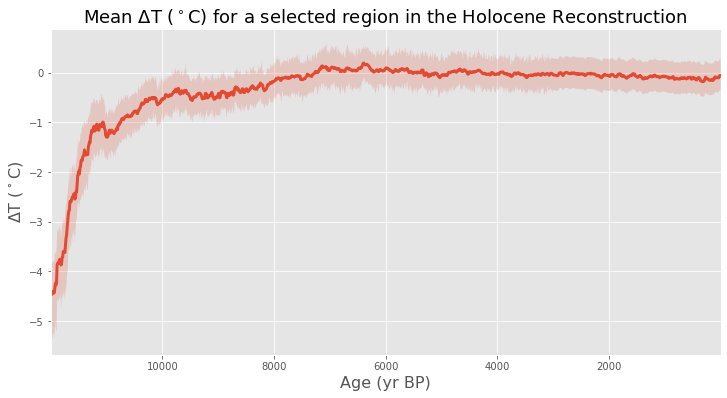

In [10]:
# Make a time series
f,ax1 = plt.subplots(1,1,figsize=(12,6))
ax1.plot(ages,tas_mean_region,linewidth=3)
ax1.fill_between(ages,np.percentile(tas_ens_region,2.5,axis=1),np.percentile(tas_ens_region,97.5,axis=1),alpha=0.2)
ax1.set_xlim(max(ages),min(ages))
ax1.set_ylabel('$\Delta$T ($^\circ$C)',fontsize=16)
ax1.set_xlabel('Age (yr BP)',fontsize=16)
ax1.set_title('Mean $\Delta$T ($^\circ$C) for a selected region in the Holocene Reconstruction',fontsize=18,loc='center')
plt.show()

## Closing thoughts

This code demonstrates how to load a NetCDF file, look at the data, then make a map and a time series. There are more advanced ways of interacting with data in python, such as using more xarray functionality. You can explore those features as you become more familiar with python.

Feel free to copy this code and use it yourself.